# Anomaly detection with Autoencoders

Autoencoders can be trained using supervised learning techniques to detect fraudulent transactions in the following manner:
- Train the autoencoder with only legitimate transactions. The idea is that the autoencoder will be good at reconstructing legitimate transactions (with a low reconstruction loss)
- When a fraudulent transaction is fed into the autoencoder, it will not be able to reconstruct it onto a legitimate transaction well, therefore the reconstruction loss should be significantly higher for these transactions.


In [ ]:
!pip install -q -U keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.9/128.9 kB 1.5 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
import keras
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import keras_tuner as kt
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import roc_curve, auc, roc_auc_score
from keras.regularizers import l2
from imblearn.over_sampling import SMOTE
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score

# 1. Autoencoder trained with only legit transactions from undersampled dataset

In [ ]:
# Get all the transactions (pre-scaled) before the lables had been removed so you can separate the fraud and legit transactions
all_tx = pd.read_csv('/content/drive/MyDrive/final year/btc_tx_anomaly_detection/data/cleaned_undersampled_data.csv', index_col=False)

In [ ]:
# separate labels from data
y = all_tx['is_fraud']
X = all_tx.drop('is_fraud', axis=1)

### 1.1.1 Split the dataset into legit and fraud transactions (They will be used separately to train and test the autoencoder)

In [ ]:
# separate legit from fraud (with labels)
legit = all_tx[all_tx['is_fraud']==0]
fraud= all_tx[all_tx['is_fraud']==1]

In [ ]:
legit_labels = legit['is_fraud']
fraud_labels = fraud['is_fraud']

legit = legit.drop('is_fraud', axis=1)

### 1.1.2 Split into training, validation and test

Split the legit transaction data separately

I need the legit transactions to be split into train, val and test (don't need test)
I then need another train, val and test set which will include a number of mixed transactions (only need test)

In [ ]:
def split_data(x, y, train_ratio=0.80, validation_ratio=0.10, test_ratio=0.10, random_state=42):
    """
    Split the data into training, validation, and test sets along with their corresponding labels.

    Parameters:
    - x: Features
    - y: Labels
    - train_ratio: Ratio of the training set (default: 0.80)
    - validation_ratio: Ratio of the validation set (default: 0.10)
    - test_ratio: Ratio of the test set (default: 0.10)
    - random_state: Random seed for reproducibility (default: 42)

    Returns:
    - x_train: Training features
    - x_val: Validation features
    - x_test: Test features
    - y_train: Training labels
    - y_val: Validation labels
    - y_test: Test labels
    """
    # Split into training and test data
    x_train, x_test, y_train, y_test = train_test_split(
        x,
        y,
        test_size=1 - train_ratio,
        random_state=random_state,
        stratify=y
    )

    # Create validation set as 10% of the original dataset
    x_train, x_val, y_train, y_val = train_test_split(
        x_train,
        y_train,
        test_size=validation_ratio / (test_ratio + validation_ratio),
        random_state=random_state,
        stratify=y_train
    )

    return x_train, x_val, x_test, y_train, y_val, y_test

In [ ]:
legit_train, legit_val, legit_test, legit_label_train, legit_label_val, legit_label_test = split_data(legit, legit_labels)
X_train, X_val, X_test, y_train, y_val, y_test = split_data(X, y)

### 1.2 Build autoencoder

In [ ]:
def build_autoencoder(loss, input_dim, latent_dim, dense_neurons, dense_activation, output_activation, optimizer, learning_rate):
  encoder = keras.models.Sequential()
  decoder = keras.models.Sequential()

  #check if there's any dropout layers

  # Create the encoder
  # Create the input layer
  encoder.add(keras.layers.Dense(dense_neurons[0], input_shape=(input_dim, )))

  # create the dense layers
  for i in range(1, len(dense_neurons)):
    encoder.add(keras.layers.Dense(dense_neurons[i], activation=dense_activation))
    encoder.add(keras.layers.Dropout(0.2))

  # Create the output layer
  encoder.add(keras.layers.Dense(latent_dim, activation=output_activation))


  # Create the decoder
  # Create the input layer
  decoder.add(keras.layers.Dense(dense_neurons[-1], input_shape=(latent_dim, )))

  # create the dense layers
  for i in range(len(dense_neurons) - 2, 0, -1):
    decoder.add(keras.layers.Dense(dense_neurons[i], activation=dense_activation))
    decoder.add(keras.layers.Dropout(0.2))

  # Create the output layer
  decoder.add(keras.layers.Dense(input_dim, activation=output_activation))

  # Create optimiser
  if optimizer == 'sgd':
        optimizer = keras.optimizers.SGD(learning_rate=learning_rate)
  else:
        optimizer = keras.optimizers.Adam(learning_rate=learning_rate)


  anomaly_autoencoder = keras.models.Sequential([encoder, decoder])
  # Compile the model
  anomaly_autoencoder.compile(optimizer=optimizer, loss=loss)

  return anomaly_autoencoder

In [ ]:
# Use K means to get the threshold
from sklearn.cluster import KMeans

def get_threshold(reconstruction_errors):
  kmean = KMeans(n_clusters=2, random_state=42, n_init='auto').fit(reconstruction_errors)
  centers = kmean.cluster_centers_
  return (centers[0] + centers[1]) /2


In [ ]:
# Plot ROC curve
def plot_roc(y_pred, fpr, tpr):

  roc_auc = auc(fpr, tpr)

  plt.figure(figsize=(4, 4))
  plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
  plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess')


  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver Operating Characteristic (ROC) Curve')
  plt.legend(loc='lower right')
  plt.show()

In [ ]:
def display_cm(y_true, y_pred):

  cm = confusion_matrix(y_true, predictions)

  # Plot the confusion matrix as a heatmap
  plt.figure(figsize=(8, 6))

  group_counts = ['{0:0.0f}'.format(value) for value in cm.flatten()]
  group_percentages = ['{:.2%}'.format(value) for value in (cm / cm.sum(axis=1)[:, np.newaxis]).flatten()]
  labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_counts,group_percentages)]

  labels = np.asarray(labels).reshape(2,2)
  tick_labels = ['Non-Fraud', 'Fraud']
  sns.heatmap(cm, annot=labels, fmt='s', xticklabels=tick_labels, yticklabels=tick_labels)

  plt.title('Confusion Matrix')
  plt.xlabel('Predicted')
  plt.ylabel('Actual')
  plt.show()

  # Print classification report for additional metrics
  print("Classification Report:")
  print(classification_report(y_true, predictions))


### 1.3 Train Autoencoder

In [ ]:
ae_1 = build_autoencoder(loss='mse', input_dim=11, latent_dim=3, dense_neurons=[32, 16, 8],
                                   dense_activation='relu', output_activation='relu',
                                   optimizer='adam', learning_rate=0.001)



checkpoint_filepath = '/content/drive/MyDrive/final year/btc_tx_anomaly_detection/models/autoencoder/checkpoint_1'

#early_stopping = EarlyStopping(monitor='val_f1_score', mode='max', patience=8)

checkpoint = ModelCheckpoint(filepath=checkpoint_filepath,
                             monitor='val_loss', mode='min', save_best_only=True)

# Train the model on only legitimate transactions and get the decoder to reconstruct data into legit transactions
history = ae_1.fit(legit_train, legit_train,
                                  validation_data=[legit_val, legit_val], epochs=60, batch_size=100, callbacks=[checkpoint])

Epoch 1/60
45/45 [==============================] - 6s 58ms/step - loss: 0.0240 - val_loss: 0.0029
Epoch 2/60
45/45 [==============================] - 0s 8ms/step - loss: 0.0076 - val_loss: 0.0037
Epoch 3/60
45/45 [==============================] - 0s 8ms/step - loss: 0.0053 - val_loss: 0.0035
Epoch 4/60
45/45 [==============================] - 0s 8ms/step - loss: 0.0045 - val_loss: 0.0032
Epoch 5/60
45/45 [==============================] - 2s 48ms/step - loss: 0.0040 - val_loss: 0.0028
Epoch 6/60
45/45 [==============================] - 3s 59ms/step - loss: 0.0037 - val_loss: 0.0028
Epoch 7/60
45/45 [==============================] - 3s 72ms/step - loss: 0.0035 - val_loss: 0.0025
Epoch 8/60
45/45 [==============================] - 1s 11ms/step - loss: 0.0033 - val_loss: 0.0026
Epoch 9/60
45/45 [==============================] - 2s 49ms/step - loss: 0.0030 - val_loss: 0.0024
Epoch 10/60
45/45 [==============================] - 2s 45ms/step - loss: 0.0028 - val_loss: 0.0022
Epoch 11/60


In [ ]:
checkpoint_filepath = '/content/drive/MyDrive/final year/btc_tx_anomaly_detection/models/autoencoder/checkpoint_1'
ae_1 = keras.models.load_model(checkpoint_filepath)

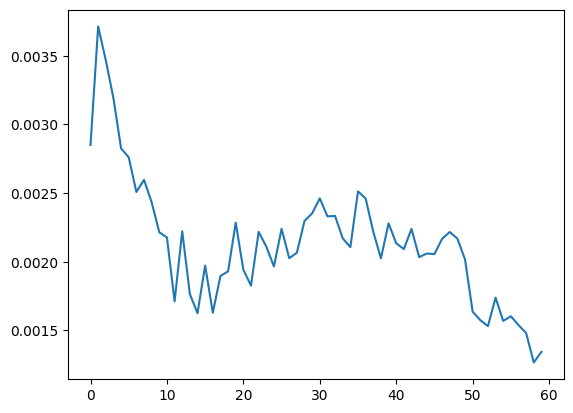

In [ ]:
training_loss = history.history['val_loss']
plt.plot(training_loss)

### 1.4 Predict Reconstruction error on undersampled dataset containing legit and fraud transactions

71/71 [==============================] - 0s 3ms/step


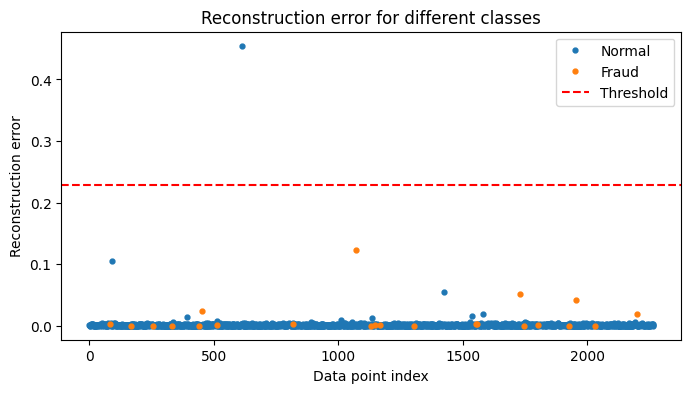

In [ ]:
# Use X-test which contains both fraudulent and legit transactions for predictions
mixed_tx_reconstructed_pred = ae_1.predict(X_test)
# get the reconstruction loss for each transaction
mixed_reconstruction_loss = keras.losses.mse(mixed_tx_reconstructed_pred, X_test)

threshold_ae_1 = get_threshold(mixed_reconstruction_loss.numpy().reshape(-1, 1))

test_error_df = pd.DataFrame({'Reconstruction_loss': mixed_reconstruction_loss, 'True_class': y_test}).reset_index(drop=True)

groups = test_error_df.groupby('True_class')
fig, ax = plt.subplots(figsize=(8, 4))

for name, group in groups:
    ax.plot(group.index, group.Reconstruction_loss, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")

#Draw a horizontal line at the calculated threshold
plt.axhline(y=threshold_ae_1[0], color='red', linestyle='--', label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

In [ ]:
ae_1_pred = mixed_reconstruction_loss.numpy().copy()

predictions = (ae_1_pred > threshold_ae_1).astype(int)

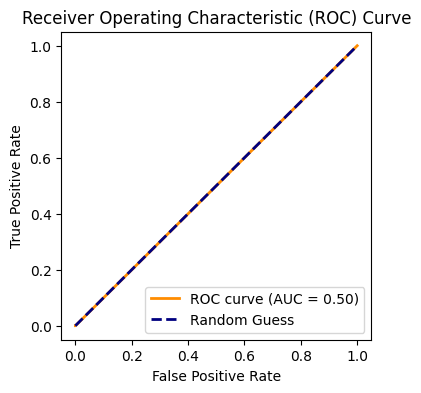

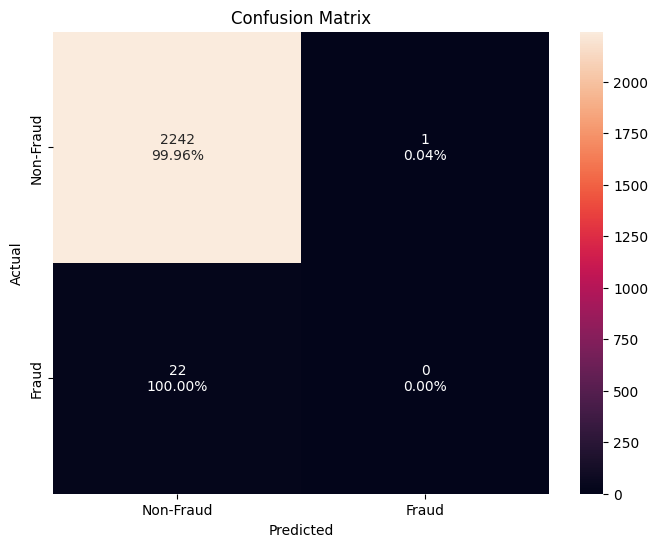

Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99      2243
         1.0       0.00      0.00      0.00        22

    accuracy                           0.99      2265
   macro avg       0.50      0.50      0.50      2265
weighted avg       0.98      0.99      0.99      2265



In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, predictions, pos_label=1)
plot_roc(predictions, fpr, tpr)
# take a deeper look and see how the model predicted the samples
display_cm(y_test, predictions)

### 1.5 Evaluate

By the looks of things, the autoencoder may not have learned from the legitimate transactions.

What I can do, is because this autoencoder is only trained on legitimate transactions, I can use more data. Originally, I picked only around 11,000 samples of legitimate transactions to try and overcome the imbalance problem. But since we're not training a binary classifier, we can utilise the full dataset (or at least a lot more than 11,000).

To avoid using too much computation resources (which I don't have), I will take around 100-200k non-fraud transaction from the original dataset to use to train this autoencoder. This dataset will not have the additional features which I gathered from blockchain.com API including size, fee etc. Let's see how this does.

Once ive got the reconstruction loss - use another function to determine the thresholds

Then use another anomlay detection algorithm with the same metrrics to compare

# 2. Train autoencoder with a more samples

### 1.1 Get more sample data from original dataset

In [ ]:
bitcoin_txs = pd.DataFrame()
fraud_txs = pd.DataFrame()

# Load the dataset in chunks
for chunk in pd.read_csv('/content/drive/MyDrive/final year/DG_out.csv', chunksize=100000):

    # Filter rows a transaction has any malicious inputs, outputs or itself is malicious
    malicious_rows = chunk[(chunk['all_malicious']==1)]

    # Concatenate the malicious rows to the DataFrame
    fraud_txs = pd.concat([fraud_txs, malicious_rows])

    # Take a random sample from each chunk making sure they are non-fraudulent
    data_samples = chunk[(chunk['in_malicious']==0) & (chunk['out_malicious']==0) & (chunk['is_malicious']==0) & (chunk['out_and_tx_malicious']==0) & (chunk['all_malicious']==0)].sample(n=600, random_state=42)

    # Add each sample
    bitcoin_txs = pd.concat([bitcoin_txs, data_samples])

# Concat to a single dataset
bitcoin_txs = pd.concat([bitcoin_txs, fraud_txs])

# write this to file
bitcoin_txs.to_csv('/content/drive/MyDrive/final year/btc_tx_anomaly_detection/data/oversampled_data.csv', index=False)

In [ ]:
# contrains both fraud and legit
oversampled = pd.read_csv('/content/drive/MyDrive/final year/btc_tx_anomaly_detection/data/oversampled_data.csv', index_col=False)

In [ ]:
oversampled = oversampled.drop(['tx_hash', 'in_malicious', 'out_malicious', 'is_malicious', 'all_malicious'], axis=1)

### 1.1.2 Scale

In [ ]:
scaler = MinMaxScaler()
oversampled = pd.DataFrame(scaler.fit_transform(oversampled), columns = oversampled.columns)

### 2.2 Split into training, validation and test again

In [ ]:
# data with both legit and fraud txs
y_os = oversampled['out_and_tx_malicious']
X_os= oversampled.drop('out_and_tx_malicious', axis=1)

In [ ]:
# split them up to get only legit txs
legit_os = oversampled[oversampled['out_and_tx_malicious']==0]
fraud_os= oversampled[oversampled['out_and_tx_malicious']==1]

In [ ]:
# remove label column
legit_labels_os = legit_os['out_and_tx_malicious']
legit_os = legit_os.drop('out_and_tx_malicious', axis=1)

In [ ]:
# split into training val and test
legit_train_os, legit_val_os, legit_test_os, legit_label_os_train, legit_label_os_val, legit_label_os_test = split_data(legit_os, legit_labels_os)
X_train_os, X_val_os, X_test_os, y_train_os, y_val_os, y_test_os = split_data(X_os, y_os)

### 2.3 Train a new autoencoder with this new oversampled dataset

Notice how this has fewer features (7 compared to 11)
This is because the other 4 features were gathered from the blockchain.com API. I can't spare the resources to request 200k API calls so we'll leave these features out for this round of training.

In [ ]:
ae_2 = build_autoencoder(loss='mse', input_dim=7, latent_dim=3, dense_neurons=[32, 16, 8],
                                   dense_activation='relu', output_activation='relu',
                                   optimizer='adam', learning_rate=0.001)


checkpoint_filepath = '/content/drive/MyDrive/final year/btc_tx_anomaly_detection/models/autoencoder/checkpoint_2'

#early_stopping = EarlyStopping(monitor='val_f1_score', mode='max', patience=8)

checkpoint = ModelCheckpoint(filepath=checkpoint_filepath,
                             monitor='val_loss', mode='min', save_best_only=True)

# Train the model on only legitimate transactions and get the decoder to reconstruct data into legit transactions
history = ae_2.fit(legit_train_os, legit_train_os,
                                  validation_data=[legit_val_os, legit_val_os], epochs=60, batch_size=100, callbacks=[checkpoint])

ae_2 = keras.models.load_model(checkpoint_filepath)


Epoch 1/60
733/733 [==============================] - 8s 8ms/step - loss: 3.3662e-05 - val_loss: 3.0567e-05
Epoch 2/60
733/733 [==============================] - 8s 12ms/step - loss: 2.6580e-05 - val_loss: 1.7236e-05
Epoch 3/60
733/733 [==============================] - 4s 5ms/step - loss: 2.4230e-05 - val_loss: 2.2168e-05
Epoch 4/60
733/733 [==============================] - 6s 9ms/step - loss: 2.3614e-05 - val_loss: 1.6297e-05
Epoch 5/60
733/733 [==============================] - 7s 9ms/step - loss: 2.1364e-05 - val_loss: 1.5641e-05
Epoch 6/60
733/733 [==============================] - 5s 7ms/step - loss: 1.7664e-05 - val_loss: 1.2984e-05
Epoch 7/60
733/733 [==============================] - 5s 7ms/step - loss: 1.9712e-05 - val_loss: 1.9198e-05
Epoch 8/60
733/733 [==============================] - 7s 9ms/step - loss: 1.6249e-05 - val_loss: 8.5132e-06
Epoch 9/60
733/733 [==============================] - 6s 8ms/step - loss: 1.7652e-05 - val_loss: 7.6861e-06
Epoch 10/60
733/733 [======

In [ ]:
checkpoint_filepath = '/content/drive/MyDrive/final year/btc_tx_anomaly_detection/models/autoencoder/checkpoint_2'
ae_2 = keras.models.load_model(checkpoint_filepath)

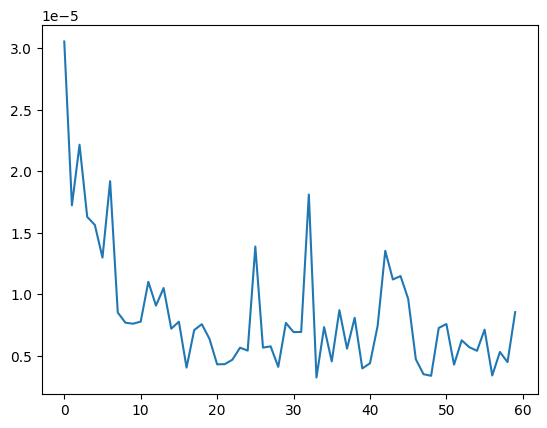

In [ ]:
training_loss = history.history['val_loss']
plt.plot(training_loss)

### 2.3 Predict reconstruction loss using oversampled dataset containing legit and fraud transactions

1145/1145 [==============================] - 5s 5ms/step


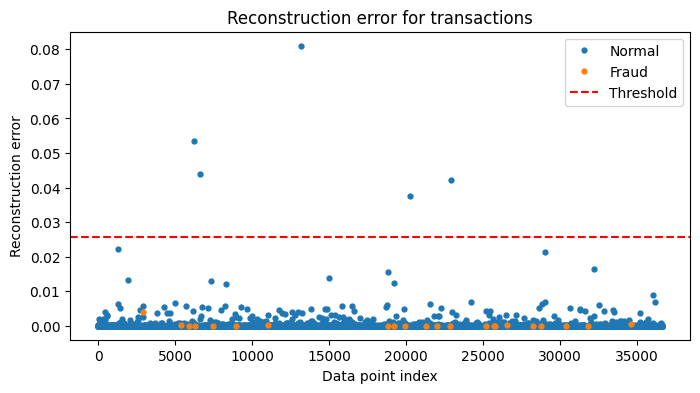

In [ ]:
# Use X-test which contains both fraudulent and legit transactions for predictions
mixed_tx_os_reconstructed = ae_2.predict(X_test_os)
mixed_os_reconstruction_loss = keras.losses.mse(mixed_tx_os_reconstructed, X_test_os)

threshold_ae_2 = get_threshold(mixed_os_reconstruction_loss.numpy().reshape(-1, 1))

test_error_df_os = pd.DataFrame({'Reconstruction_error': mixed_os_reconstruction_loss, 'True_class': y_test_os}).reset_index(drop=True)

groups = test_error_df_os.groupby('True_class')
fig, ax = plt.subplots(figsize=(8, 4))

for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")

#Draw a horizontal line at the calculated threshold
plt.axhline(y=threshold_ae_2[0], color='red', linestyle='--', label='Threshold')
ax.legend()
plt.title("Reconstruction error for transactions")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

### 2.4 Evaluate

In [ ]:
ae_2_pred = mixed_os_reconstruction_loss.numpy().copy()

predictions = (ae_2_pred > threshold_ae_2).astype(int)

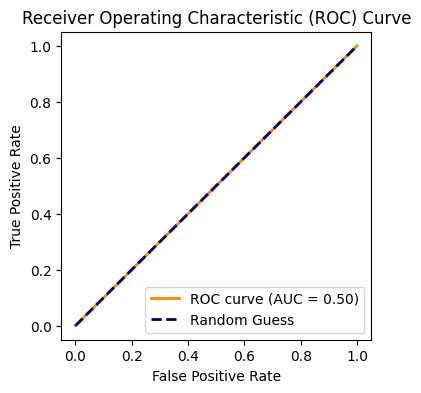

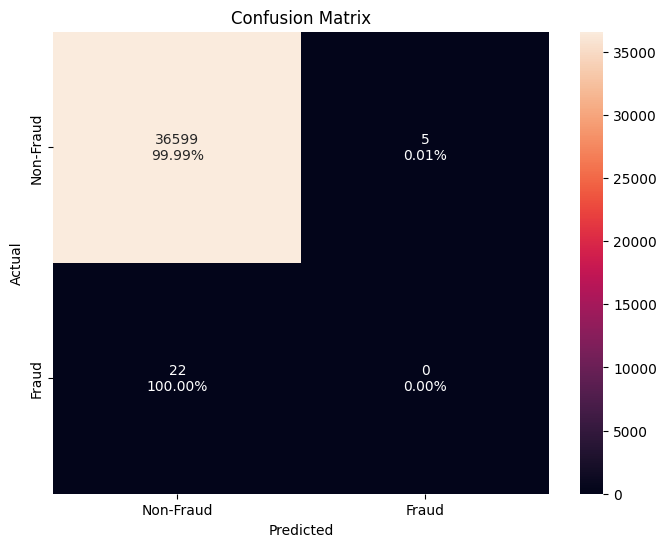

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     36604
         1.0       0.00      0.00      0.00        22

    accuracy                           1.00     36626
   macro avg       0.50      0.50      0.50     36626
weighted avg       1.00      1.00      1.00     36626



In [ ]:
fpr, tpr, thresholds = roc_curve(y_test_os, predictions, pos_label=1)
plot_roc(predictions, fpr, tpr)
# take a deeper look and see how the model predicted the samples
display_cm(y_test_os, predictions)

# 3. Use Keras tuner to find best hyperparameters for the autoencoder and train autoencoder again using these hyperparameters with legit transactions from the oversampled dataset

### 3.1 Build Keras Tuner model

In [ ]:
def model_builder(hp):
  encoder = keras.models.Sequential()
  decoder = keras.models.Sequential()

  # Define the hyperparameters
  input_shape = (7, )
  hp_activation = hp.Choice('activation', values=['relu', 'selu'])
  hp_input_neurons = hp.Int('input_layer', min_value=1, max_value=200, step=10)
  hp_dense_layers = hp.Int('dense_layer', min_value=0, max_value=8, step=1)
  hp_dense_neurons = hp.Int('dense_neurons', min_value=1, max_value=200, step=10)
  hp_optimizer = hp.Choice('optimiser', values=['SGD', 'Adam'])
  hp_learning_rate = hp.Choice('learning_rate', values=[0.001, 0.005, 0.01, 0.05, 0.1])
  hp_dropout_prob = hp.Float('dropout_prob', min_value=0.0, max_value=1.0, step=0.1, default=0.0)
  hp_dropout_rate = hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1)
  hp_latent_dim = hp.Int('latent_dim', min_value=1, max_value=5, step=1)

  # Create the encoder
  # Create the input layer
  encoder.add(keras.layers.Dense(hp_input_neurons, input_shape=input_shape))

  # create the dense layers
  for i in range(hp_dense_layers):
    neurons = (int)(hp_dense_neurons / (i+1))
    encoder.add(keras.layers.Dense(neurons, activation=hp_activation))
    # Add drop out layer
    if hp_dropout_prob > 0.5:
      encoder.add(keras.layers.Dropout(hp_dropout_rate))

  # Create the output layer
  encoder.add(keras.layers.Dense(hp_latent_dim, activation=hp_activation))


  # Create the decoder
  # Create the input layer
  decoder.add(keras.layers.Dense(hp_input_neurons, input_shape=(hp_latent_dim, )))

  # create the dense layers
  for i in range(hp_dense_layers):
    neurons = (int)(hp_dense_neurons / (i+1))
    decoder.add(keras.layers.Dense(neurons, activation=hp_activation))
    # Add drop out layer
    if hp_dropout_prob > 0.5:
      encoder.add(keras.layers.Dropout(hp_dropout_rate))

  # Create the output layer
  decoder.add(keras.layers.Dense(7, activation=hp_activation))

  # Create optimiser
  if hp_optimizer == 'SGD':
        optimizer = keras.optimizers.SGD(learning_rate=hp_learning_rate)
  else:
        optimizer = keras.optimizers.Adam(learning_rate=hp_learning_rate)


  anomaly_autoencoder = keras.models.Sequential([encoder, decoder])
  # Compile the model
  anomaly_autoencoder.compile(optimizer=optimizer, loss='msle')

  return anomaly_autoencoder

In [ ]:
tuner = kt.Hyperband(model_builder,
                     objective=kt.Objective("val_loss", direction="min"),
                     max_epochs=10,
                     factor=3,
                     directory='/content/drive/MyDrive/final year/btc_tx_anomaly_detection/Experiments/Autoencoder/',
                     project_name='AE_model_1')

Reloading Tuner from /content/drive/MyDrive/final year/btc_tx_anomaly_detection/Experiments/Autoencoder/AE_model_1/tuner0.json


In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

### 3.1.2 Search for best hyperparams on model oversampled dataset

In [ ]:
tuner.search(legit_train_os, legit_train_os, epochs=30, validation_data=[legit_val_os, legit_val_os], callbacks=[early_stopping])

Trial 30 Complete [00h 02m 24s]
val_loss: 3.858981290250085e-05

Best val_loss So Far: 2.2159601940074936e-05
Total elapsed time: 00h 35m 37s


### 3.1.3 Retreive best hyperparams/model

In [ ]:
best_hps = tuner.get_best_hyperparameters()[0]

In [ ]:
best_hps.values

{'activation': 'selu',
 'input_layer': 91,
 'dense_layer': 3,
 'dense_neurons': 11,
 'optimiser': 'SGD',
 'learning_rate': 0.005,
 'dropout_prob': 0.30000000000000004,
 'dropout_rate': 0.30000000000000004,
 'latent_dim': 5,
 'tuner/epochs': 10,
 'tuner/initial_epoch': 0,
 'tuner/bracket': 0,
 'tuner/round': 0}

In [ ]:
best_model = tuner.get_best_models()[0]

### 3.2 Use this model to predict reconstuction error for oversampled dataset with legit and fraud transactions

1145/1145 [==============================] - 7s 6ms/step


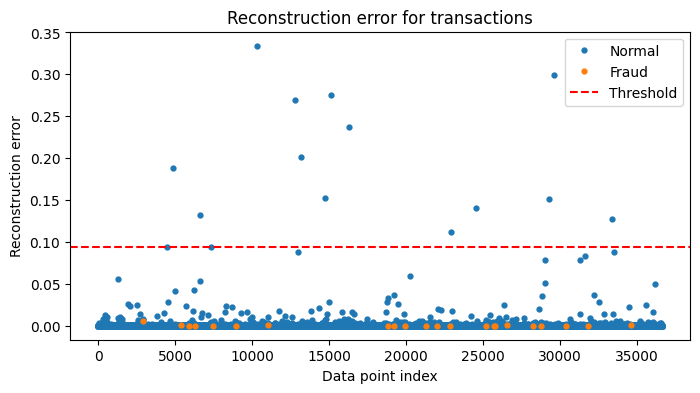

In [ ]:
# Use X-test which contains both fraudulent and legit transactions for predictions
tuned_mixed_tx_os_reconstructed = best_model.predict(X_test_os)
tuned_mixed_os_reconstruction_loss = keras.losses.mse(tuned_mixed_tx_os_reconstructed, X_test_os)

threshold_tuned_ae = get_threshold(tuned_mixed_os_reconstruction_loss.numpy().reshape(-1, 1))

tuned_test_error_df_os = pd.DataFrame({'Reconstruction_error': tuned_mixed_os_reconstruction_loss, 'True_class': y_test_os}).reset_index(drop=True)

groups = tuned_test_error_df_os.groupby('True_class')
fig, ax = plt.subplots(figsize=(8, 4))

for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")

plt.axhline(y=threshold_tuned_ae[0], color='red', linestyle='--', label='Threshold')
ax.legend()
plt.title("Reconstruction error for transactions")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

### 3.3 Evaluate

In [ ]:
tuned_ae_pred = tuned_mixed_os_reconstruction_loss.numpy().copy()

predictions = (tuned_ae_pred > threshold_tuned_ae).astype(int)

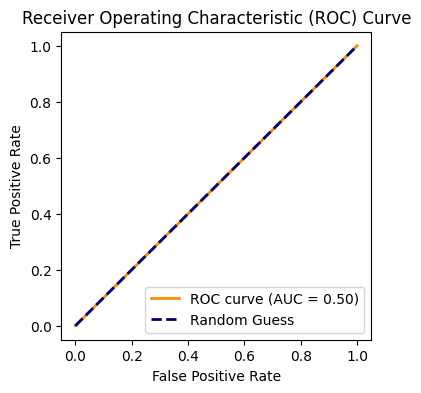

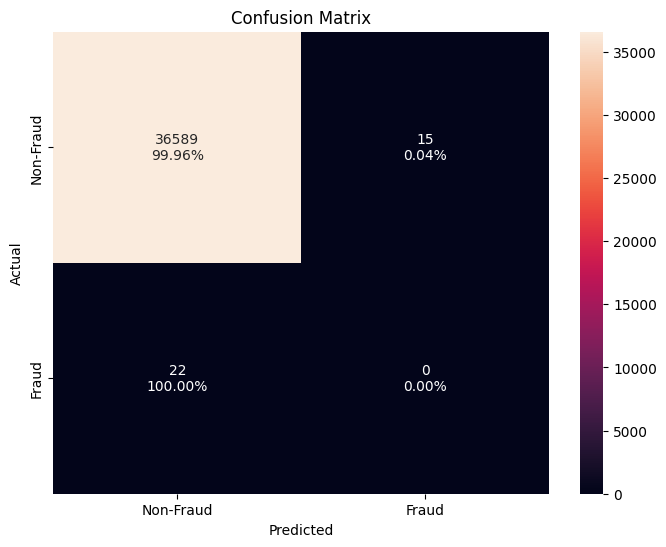

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     36604
         1.0       0.00      0.00      0.00        22

    accuracy                           1.00     36626
   macro avg       0.50      0.50      0.50     36626
weighted avg       1.00      1.00      1.00     36626



In [ ]:
fpr, tpr, thresholds = roc_curve(y_test_os, predictions, pos_label=1)
plot_roc(predictions, fpr, tpr)
# take a deeper look and see how the model predicted the samples
display_cm(y_test_os, predictions)

### I've read here: [Anomaly detection in blockchain (Shafiq 2019)](https:/trepo.tuni.fi/handle/10024/118552) that the right-skewness of the data can cause issues with model training. In this paper, shafiq proposed log-scaling the data in order to even this data distribution. Let's give that a go and use our autoencoder again to see if it makes any difference

# 4. Log scale data and train again

### 4.1.1 Log scale the data

In [ ]:
# contrains both fraud and legit
oversampled = pd.read_csv('/content/drive/MyDrive/final year/btc_tx_anomaly_detection/data/oversampled_data.csv', index_col=False)

In [ ]:
oversampled = oversampled.drop(['tx_hash', 'in_malicious', 'out_malicious', 'is_malicious', 'all_malicious'], axis=1)

In [ ]:
oversampled_labels = oversampled['out_and_tx_malicious']

In [ ]:
# Log scale to normalize the data
scaled_df = oversampled.copy()

scaled_df['indegree'] = np.log1p(scaled_df['indegree'])
scaled_df['outdegree']= np.log1p(scaled_df['outdegree'])
scaled_df['in_btc'] = np.log1p(scaled_df['in_btc'])
scaled_df['out_btc']= np.log1p(scaled_df['out_btc'])
scaled_df['total_btc']= np.log1p(scaled_df['total_btc'])
scaled_df['mean_in_btc']= np.log1p(scaled_df['mean_in_btc'])
scaled_df['mean_out_btc']= np.log1p(scaled_df['mean_out_btc'])

# RobustScaler is less prone to outliers.
from sklearn.preprocessing import RobustScaler
rob_scaler = RobustScaler()

scaled_df['indegree'] = rob_scaler.fit_transform(scaled_df['indegree'].values.reshape(-1,1))
scaled_df['outdegree'] = rob_scaler.fit_transform(scaled_df['outdegree'].values.reshape(-1,1))
scaled_df['in_btc'] = rob_scaler.fit_transform(scaled_df['in_btc'].values.reshape(-1,1))
scaled_df['out_btc'] = rob_scaler.fit_transform(scaled_df['out_btc'].values.reshape(-1,1))
scaled_df['total_btc'] = rob_scaler.fit_transform(scaled_df['total_btc'].values.reshape(-1,1))
scaled_df['mean_in_btc'] = rob_scaler.fit_transform(scaled_df['mean_in_btc'].values.reshape(-1,1))
scaled_df['mean_out_btc'] = rob_scaler.fit_transform(scaled_df['mean_out_btc'].values.reshape(-1,1))

In [ ]:
legit_log_df = scaled_df[scaled_df['out_and_tx_malicious']==0]
legit_log_labels = scaled_df['out_and_tx_malicious']

In [ ]:
legit_log_df = scaled_df.drop('out_and_tx_malicious', axis=1)

### 4.1.2 Split into training and test data

In [ ]:
X_train_log, X_val_log, X_test_log, y_train_log, y_val_log, y_test_log = split_data(legit_log_df, legit_log_labels)

### 4.2 Train using logged data

In [ ]:
ae_3 = build_autoencoder(loss='msle', input_dim=7, latent_dim=3, dense_neurons=[32, 16, 8],
                                   dense_activation='relu', output_activation='relu',
                                   optimizer='adam', learning_rate=0.001)

checkpoint_filepath = '/content/drive/MyDrive/final year/btc_tx_anomaly_detection/models/autoencoder/checkpoint_3'

#early_stopping = EarlyStopping(monitor='val_f1_score', mode='max', patience=8)

checkpoint = ModelCheckpoint(filepath=checkpoint_filepath,
                             monitor='val_loss', mode='min', save_best_only=True)

# Train the model on only legitimate transactions and get the decoder to reconstruct data into legit transactions
history = ae_3.fit(X_train_log, X_train_log,
                                  validation_data=[X_val_log, X_val_log], epochs=60, batch_size=250, callbacks=[checkpoint])

ae_3 = keras.models.load_model(checkpoint_filepath)


Epoch 1/60
293/293 [==============================] - 14s 12ms/step - loss: 0.0774 - val_loss: 0.0128
Epoch 2/60
293/293 [==============================] - 3s 10ms/step - loss: 0.0280 - val_loss: 0.0100
Epoch 3/60
293/293 [==============================] - 3s 9ms/step - loss: 0.0230 - val_loss: 0.0101
Epoch 4/60
293/293 [==============================] - 3s 10ms/step - loss: 0.0211 - val_loss: 0.0103
Epoch 5/60
293/293 [==============================] - 2s 7ms/step - loss: 0.0196 - val_loss: 0.0122
Epoch 6/60
293/293 [==============================] - 2s 6ms/step - loss: 0.0183 - val_loss: 0.0130
Epoch 7/60
293/293 [==============================] - 2s 6ms/step - loss: 0.0177 - val_loss: 0.0144
Epoch 8/60
293/293 [==============================] - 2s 6ms/step - loss: 0.0170 - val_loss: 0.0139
Epoch 9/60
293/293 [==============================] - 2s 6ms/step - loss: 0.0167 - val_loss: 0.0159
Epoch 10/60
293/293 [==============================] - 2s 6ms/step - loss: 0.0165 - val_loss: 0.

In [ ]:
checkpoint_filepath = '/content/drive/MyDrive/final year/btc_tx_anomaly_detection/models/autoencoder/checkpoint_3'
ae_3 = keras.models.load_model(checkpoint_filepath)

### 4.3 Predict reconstruction loss

1145/1145 [==============================] - 6s 5ms/step


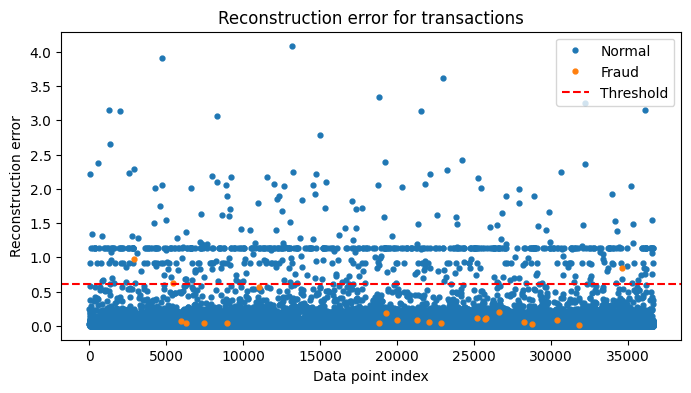

In [ ]:
# Use X-test which contains both fraudulent and legit transactions for predictions
log_mixed_tx_os_reconstructed = ae_3.predict(X_test_log)
log_mixed_os_reconstruction_loss = keras.losses.mse(log_mixed_tx_os_reconstructed, X_test_log)

threshold_ae_3 = get_threshold(log_mixed_os_reconstruction_loss.numpy().reshape(-1, 1))

log_test_error_df_os = pd.DataFrame({'Reconstruction_error': log_mixed_os_reconstruction_loss, 'True_class': y_test_log}).reset_index(drop=True)

groups = log_test_error_df_os.groupby('True_class')
fig, ax = plt.subplots(figsize=(8, 4))

for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")

plt.axhline(y=threshold_ae_3[0], color='red', linestyle='--', label='Threshold')
ax.legend()
plt.title("Reconstruction error for transactions")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

### 4.4 Evaluate

In [ ]:
ae_3_pred = log_mixed_os_reconstruction_loss.numpy().copy()

predictions = (ae_3_pred > threshold_ae_3).astype(int)

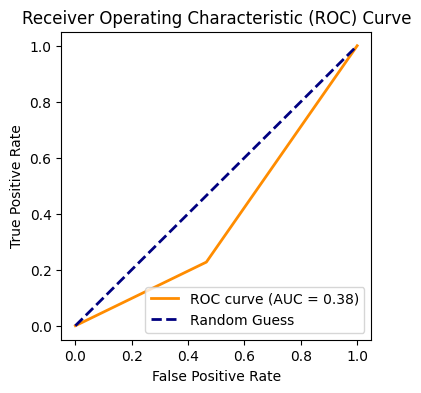

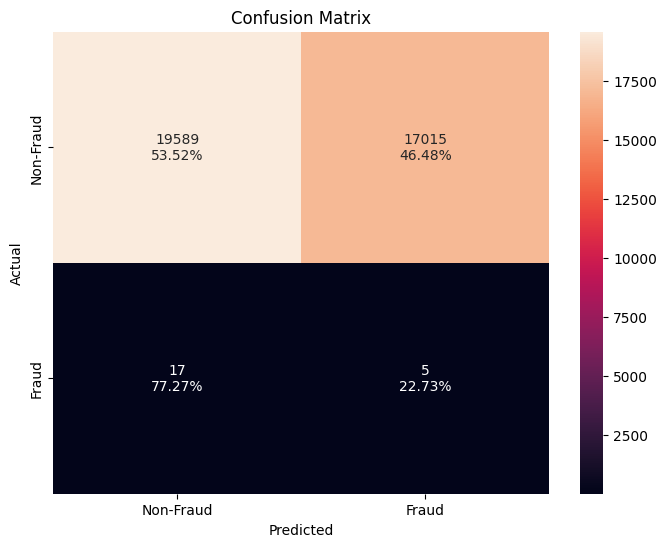

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.54      0.70     36604
           1       0.00      0.23      0.00        22

    accuracy                           0.53     36626
   macro avg       0.50      0.38      0.35     36626
weighted avg       1.00      0.53      0.70     36626



In [ ]:
fpr, tpr, thresholds = roc_curve(y_test_log, predictions, pos_label=1)
plot_roc(predictions, fpr, tpr)
# take a deeper look and see how the model predicted the samples
display_cm(y_test_log, predictions)

### 4.5 Search for the best hyperparameters to minimise mean-squared_log_error which is more appropariate for this data

In [ ]:
tuner = kt.Hyperband(model_builder,
                     objective=kt.Objective("val_loss", direction="min"),
                     max_epochs=10,
                     factor=3,
                     directory='/content/drive/MyDrive/final year/btc_tx_anomaly_detection/Experiments/Autoencoder/',
                     project_name='AE_model_log')

Reloading Tuner from /content/drive/MyDrive/final year/btc_tx_anomaly_detection/Experiments/Autoencoder/AE_model_log/tuner0.json


In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

In [ ]:
tuner.search(X_train_log, X_train_log, epochs=30, validation_data=[X_val_log, X_val_log ], callbacks=[early_stopping])

Trial 30 Complete [00h 03m 31s]
val_loss: 0.007117263972759247

Best val_loss So Far: 0.0002274529542773962
Total elapsed time: 00h 43m 27s


### 4.6 Predict using the best model

In [ ]:
best_hyper_log = tuner.get_best_hyperparameters()[0]
best_model_log = tuner.get_best_models()[0]

In [ ]:
best_hyper_log.values

{'activation': 'selu',
 'input_layer': 181,
 'dense_layer': 0,
 'dense_neurons': 101,
 'optimiser': 'Adam',
 'learning_rate': 0.01,
 'dropout_prob': 0.1,
 'dropout_rate': 0.30000000000000004,
 'latent_dim': 5,
 'tuner/epochs': 10,
 'tuner/initial_epoch': 0,
 'tuner/bracket': 0,
 'tuner/round': 0}

1145/1145 [==============================] - 2s 2ms/step


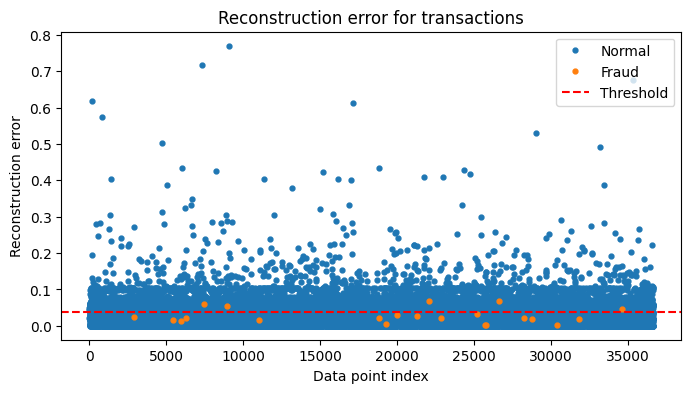

In [ ]:
# Use X-test which contains both fraudulent and legit transactions for predictions
log_mixed_tx_os_reconstructed = best_model_log.predict(X_test_log)
log_mixed_os_reconstruction_loss = keras.losses.mse(log_mixed_tx_os_reconstructed, X_test_log)

threshold_tuned_log = get_threshold(log_mixed_os_reconstruction_loss.numpy().reshape(-1, 1))

log_test_error_df_os = pd.DataFrame({'Reconstruction_error': log_mixed_os_reconstruction_loss, 'True_class': y_test_log}).reset_index(drop=True)

groups = log_test_error_df_os.groupby('True_class')
fig, ax = plt.subplots(figsize=(8, 4))

for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")

plt.axhline(y=threshold_tuned_log[0], color='red', linestyle='--', label='Threshold')
ax.legend()
plt.title("Reconstruction error for transactions")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

### 4.7 Evaluate

In [ ]:
tuned_log_pred = log_mixed_os_reconstruction_loss.numpy().copy()

predictions = (tuned_log_pred > threshold_tuned_log).astype(int)

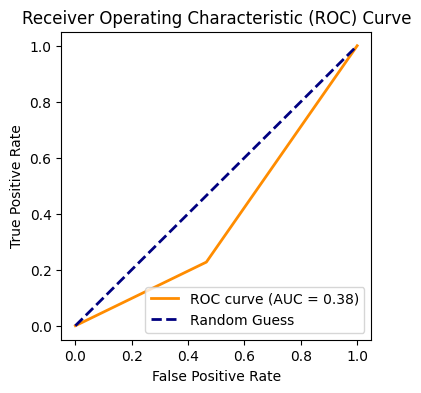

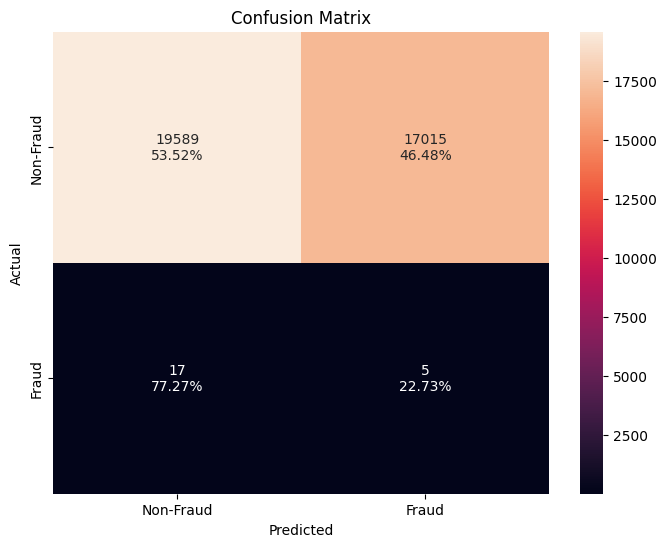

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.54      0.70     36604
           1       0.00      0.23      0.00        22

    accuracy                           0.53     36626
   macro avg       0.50      0.38      0.35     36626
weighted avg       1.00      0.53      0.70     36626



In [ ]:
fpr, tpr, thresholds = roc_curve(y_test_log, predictions, pos_label=1)
plot_roc(predictions, fpr, tpr)
# take a deeper look and see how the model predicted the samples
display_cm(y_test_log, predictions)

#Ignore these last two tests!
## Just realised -- there's no point in doing smote for these because the autoencoder is being trained on legitimate transactions only, so adding more sythetic positive samples make no sense!

I'll leave them in here for documentation purposes

## 5. Try with oversampling the dataset

In [ ]:
smote = SMOTE()

X_train_resampled_log, y_train_resampled_log = smote.fit_resample(X_train_log, y_train_log)

In [ ]:
ae_4 = build_autoencoder(loss='msle', input_dim=7, latent_dim=3, dense_neurons=[32, 16, 8],
                                   dense_activation='relu', output_activation='relu',
                                   optimizer='adam', learning_rate=0.001)

checkpoint_filepath = '/content/drive/MyDrive/final year/btc_tx_anomaly_detection/models/autoencoder/checkpoint_4'

#early_stopping = EarlyStopping(monitor='val_f1_score', mode='max', patience=8)

checkpoint = ModelCheckpoint(filepath=checkpoint_filepath,
                             monitor='val_loss', mode='min', save_best_only=True)

# Train the model on only legitimate transactions and get the decoder to reconstruct data into legit transactions
history = ae_4.fit(X_train_resampled_log, X_train_resampled_log,
                                  validation_data=[X_val_log, X_val_log], epochs=60, batch_size=250, callbacks=[checkpoint])

ae_4 = keras.models.load_model(checkpoint_filepath)


Epoch 1/60
586/586 [==============================] - 9s 12ms/step - loss: 0.1137 - val_loss: 0.0106
Epoch 2/60
586/586 [==============================] - 5s 9ms/step - loss: 0.0474 - val_loss: 0.0085
Epoch 3/60
586/586 [==============================] - 7s 12ms/step - loss: 0.0384 - val_loss: 0.0081
Epoch 4/60
586/586 [==============================] - 7s 12ms/step - loss: 0.0346 - val_loss: 0.0084
Epoch 5/60
586/586 [==============================] - 4s 6ms/step - loss: 0.0332 - val_loss: 0.0084
Epoch 6/60
586/586 [==============================] - 4s 7ms/step - loss: 0.0319 - val_loss: 0.0082
Epoch 7/60
586/586 [==============================] - 8s 14ms/step - loss: 0.0311 - val_loss: 0.0082
Epoch 8/60
586/586 [==============================] - 4s 8ms/step - loss: 0.0302 - val_loss: 0.0082
Epoch 9/60
586/586 [==============================] - 4s 7ms/step - loss: 0.0296 - val_loss: 0.0089
Epoch 10/60
586/586 [==============================] - 8s 13ms/step - loss: 0.0291 - val_loss: 0

## Results

In [ ]:
checkpoint_filepath = '/content/drive/MyDrive/final year/btc_tx_anomaly_detection/models/autoencoder/checkpoint_4'
ae_4 = keras.models.load_model(checkpoint_filepath)

1145/1145 [==============================] - 4s 3ms/step


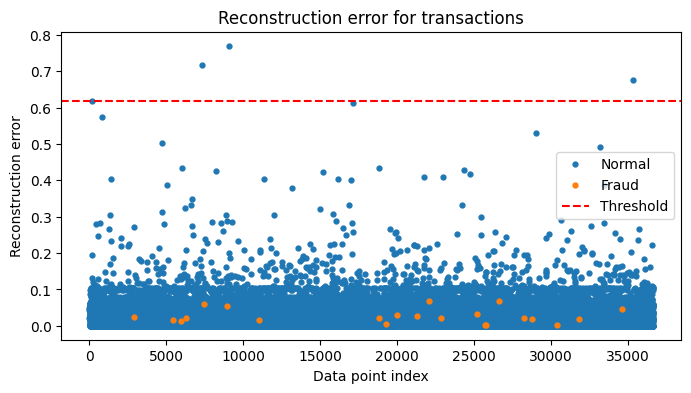

In [ ]:
# Use X-test which contains both fraudulent and legit transactions for predictions
smote_reconstructed = ae_4.predict(X_test_log)
smote_reconstructed_loss = keras.losses.mse(smote_reconstructed, X_test_log)

threshold_ae_4 = get_threshold(smote_reconstructed_loss.numpy().reshape(-1, 1))

smote_reconstructed_df = pd.DataFrame({'Reconstruction_error': smote_reconstructed_loss, 'True_class': y_test_log}).reset_index(drop=True)

groups = log_test_error_df_os.groupby('True_class')
fig, ax = plt.subplots(figsize=(8, 4))

for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")

plt.axhline(y=threshold_ae_4[0], color='red', linestyle='--', label='Threshold')
ax.legend()
plt.title("Reconstruction error for transactions")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

# Results

In [ ]:
ae_4_pred = smote_reconstructed_loss.numpy().copy()

predictions = (ae_4_pred > threshold_ae_4).astype(int)

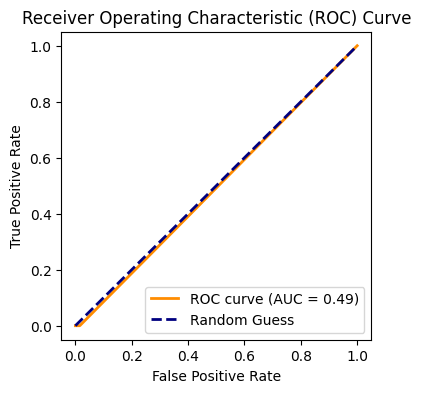

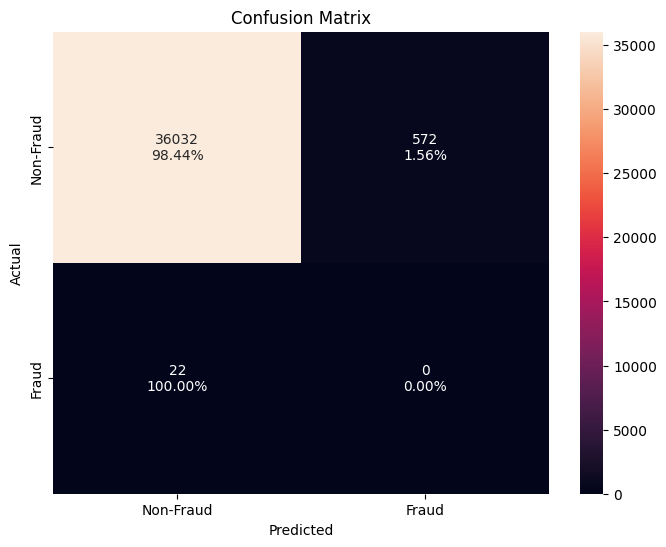

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     36604
           1       0.00      0.00      0.00        22

    accuracy                           0.98     36626
   macro avg       0.50      0.49      0.50     36626
weighted avg       1.00      0.98      0.99     36626



In [ ]:
fpr, tpr, thresholds = roc_curve(y_test_log, predictions, pos_label=1)
plot_roc(predictions, fpr, tpr)
# take a deeper look and see how the model predicted the samples
display_cm(y_test_log, predictions)